# 3. 사이킷런을 타고 떠나는 머신러닝 분류 모델 투어

In [1]:
from rich import pretty
pretty.install()

## 3.1 분류 알고리즘 선택

알고리즘을 훈련하기 위한 다섯 가지 주요 단계

1. 특성을 선택하고 훈련 샘플을 모음
2. 성능 지표를 선택
3. 분류 모델과 최적화 알고리즘을 선택
4. 모델의 성능을 평가
5. 알고리즘을 튜닝


## 3.2 사이킷런 첫걸음: 퍼셉트론 훈련


In [2]:
# data loading
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [3]:
# train test splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [4]:
print('y의 레이블 카운트: ', np.bincount(y))

y의 레이블 카운트:  [50 50 50]


In [5]:
print('y_train의 레이블 카운트: ', np.bincount(y_train))

y_train의 레이블 카운트:  [35 35 35]


In [6]:
print('y_test의 레이블 카운트: ', np.bincount(y_test))

y_test의 레이블 카운트:  [15 15 15]


In [7]:
# 표준화
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [8]:
# Perceptron training
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [9]:
# 오분류
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [10]:
# Accuracy
from sklearn.metrics import accuracy_score
print('정확도: %.3f' % accuracy_score(y_test, y_pred))

정확도: 0.978


In [11]:
print('정확도: %.3f' % ppn.score(X_test_std, y_test))

정확도: 0.978


In [12]:
# module loading
import matplotlib.pyplot as plt
import plot_decision_regions as pltreg

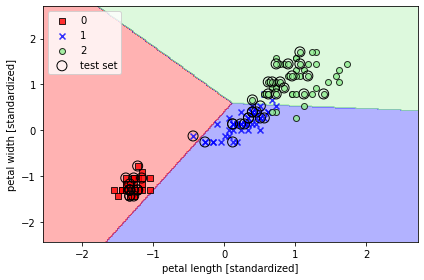

In [13]:
# 퍼셉트론 모델의 결정 경계 그리기
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
pltreg.plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3.3 로지스틱 회귀를 사용한 클래스 확률 모델링

### 3.3.1 로지스틱 회귀의 이해와 조건부 확률

구현하기 매우 쉽고 선형적으로 구분되는 클래스에 뛰어난 성능  

**소프트맥스 회귀**: https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L08_logistic_slides.pdf 참고
  - GOTO: 핸즈온 머신러닝 2판, Chapter 4.

$$\phi(z)=\frac{1}{1+e^{-z}}$$

*Example*: 어떤 붓꽃 샘플이 $\phi(z)=P(y=1|\mathbb{x;\,w})=0.8$이면, 이 샘플은 Iris-versicolor일 확률이 80%

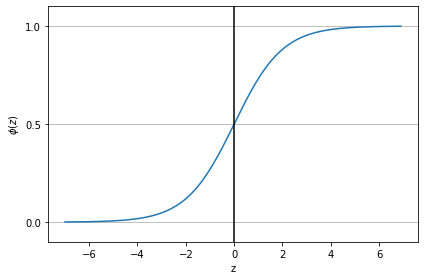

In [14]:
# 시그모이드 함수 그리기
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y 축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### 3.3.2 로지스틱 비용 함수의 가중치 학습

제곱 오차항 비용 함수:  
$$J(\mathbb{w})=\frac{1}{2}\sum_i(y^{(i)}-\phi(z^{(i)}))^2$$

로지스틱 회귀의 비용 함수:  
데이터셋에 있는 각 샘플이 서로 독립적이라고 가정, 최대화하려는 가능도 (likelihood) $L$을 정의  

$$L(w)=P(\mathbb{y}|\mathbb{x;w})=\prod_{i=1}^nP(y^{(i)}|\mathbb{x}^{(i)}\mathbb{;w}) \\
=\prod_{i=1}^n(\phi(z^{(i)}))^{y^{(i)}}(1-\phi(z^{(i)}))^{1-y^{(i)}}$$

이 공식의 (자연) 로그를 최대화 - 로그 가능도 함수  

$$l(w)=\log{L(w)}=\sum_{i=1}^n\left[y^{(i)}\log(\phi(z^{(i)}))+(1-y^{(i)})\log(1-\phi(z^{(i)}))\right]$$

1) 가능도가 매우 작을 때 일어나는 수치 상의 언더플로를 방지
2) 계수의 곱을 계수의 합으로 바꿀 수 있다. - 도함수를 구하기 쉽다.


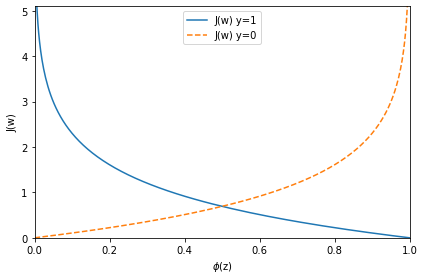

In [15]:
# 샘플이 하나인 경우 분류 비용 계산
def cost_1(z):
    return -np.log(sigmoid(z))
def cost_0(z):
    return -np.log(1-sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 3.3.3 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

최소화해야 할 비용 함수 (from above section: 3.3.2)  
logisticregressiongd.py에 LogisticRegressionGD class 구현  
Iris-setosa, versicolor 붓꽃으로 로지스틱 회귀 구현 확인 

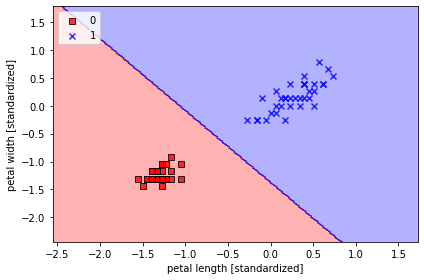

In [16]:
from logisticregressiongd import LogisticRegressionGD

X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

pltreg.plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_05.png', dpi=300)
plt.show()